In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

In [3]:
img_orig = cv2.imread('./images/03.jpg') 

In [7]:
cv2.namedWindow('original', cv2.WINDOW_NORMAL)
cv2.imshow('original', img_orig)
cv2.waitKey(0)
cv2.destroyAllWindows

<function destroyAllWindows>

In [8]:
### Scanning

In [9]:
# 1. Resize the image and set aspect ratio

In [11]:
def resizer(image, width=500):
    # get width and height
    h, w, c = image.shape

    height = int((h/w)*width)
    size = (width, height)
    image = cv2.resize(image, (width, height))
    return image, size

In [12]:
img_re, size = resizer(img_orig)
print(size)
cv2.imshow('Resize', img_re)
cv2.waitKey(0)
cv2.destroyAllWindows()

(500, 666)


### 2. Image Processing
1. Enhance
2. Grayscale
3. Blur
4. Edge Detect
5. Morphological transform
6. Countors
7. Find Four Points

In [24]:
detail = cv2.detailEnhance(img_re, sigma_s = 20, sigma_r = 0.15)
gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
# edge detection
edge_image = cv2.Canny(blur, 75, 200)
# morphological transform
kernel = np.ones((5,5), np.uint8)
dilate = cv2.dilate(edge_image, kernel, iterations=1)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)

# finding the contours
contours, hire = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02*peri, True)

    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break

cv2.drawContours(img_re, [four_points], -1, (0, 255, 0), 3)

# find four points for original image
multiplier = img_orig.shape[1] / size[0]
four_points_orig = four_points * multiplier
four_points_orig = four_points_orig.astype(int)

In [25]:
from imutils.perspective import four_point_transform

In [26]:
wrap_image = four_point_transform(img_orig, four_points_orig)

In [27]:
cv2.imshow('wrap', wrap_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## document scanning function

In [30]:

def document_scanner(image):
    img_re, size = resizer(image)
    
    detail = cv2.detailEnhance(img_re, sigma_s = 20, sigma_r = 0.15)
    gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # edge detection
    edge_image = cv2.Canny(blur, 75, 200)
    # morphological transform
    kernel = np.ones((5,5), np.uint8)
    dilate = cv2.dilate(edge_image, kernel, iterations=1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)
    
    # finding the contours
    contours, hire = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02*peri, True)
    
        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break
    
    cv2.drawContours(img_re, [four_points], -1, (0, 255, 0), 3)
    
    # find four points for original image
    multiplier = img_orig.shape[1] / size[0]
    four_points_orig = four_points * multiplier
    four_points_orig = four_points_orig.astype(int)
    
    wrap_image = four_point_transform(img_orig, four_points_orig)

    return wrap_image, four_points_orig, img_re, closing

In [31]:
img = cv2.imread('./images/03.jpg')
wrpimg, points, cnt_img, edgeimg = document_scanner(img)

In [32]:
cv2.imshow('original image', img)
cv2.imshow('resize', cnt_img)
cv2.imshow('edge', edgeimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Magic Color

In [33]:
def apply_brightness_contrast(input_img, brightness=0, contrast=0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131 * (contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [44]:
rgb = cv2.cvtColor(wrpimg, cv2.COLOR_BGR2RGB)
magic_image = apply_brightness_contrast(wrpimg, 120, 0)

In [45]:
cv2.imshow('magic image brightness 40', magic_image)
# cv2.imshow('magic image brightness 40', wrpimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

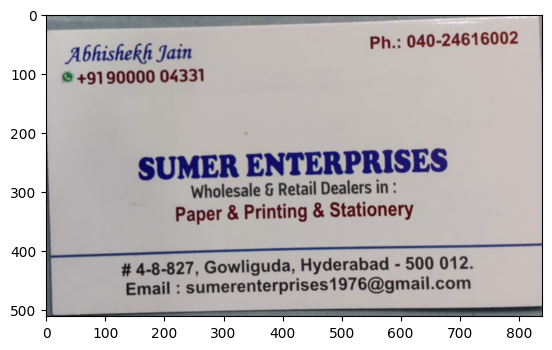

In [46]:
plt.imshow(wrpimg)

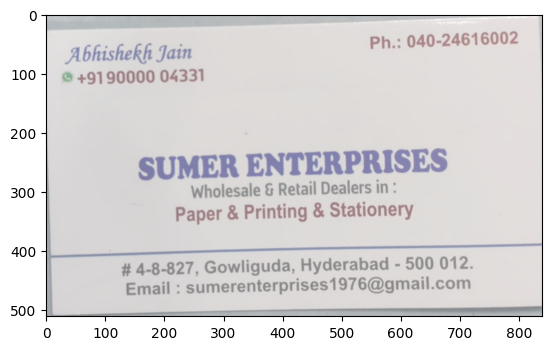

In [47]:
plt.imshow(magic_image)

### predictions


In [48]:
import predictions as pred

In [49]:
img_bbb, results = pred.getPredictions(magic_image)

E:\media\university\mini-project\udemy_course\2_DocumentScanner\predictions.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: doc_text[x[0]:x[1]], axis = 1
E:\media\university\mini-project\udemy_course\2_DocumentScanner\predictions.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['end'] = df_clean['text'].apply(lambda x: len(x)+1).cumsum() - 1
E:\media\university\mini-project\udemy_course\2_DocumentScanner\predictions.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

In [50]:
results

{'NAME': ['Jain'],
 'ORG': ['Abhishekh'],
 'DES': [],
 'PHONE': ['04024616002', '9190000'],
 'EMAIL': ['sumerenterprises1976@gmail.com'],
 'WEB': []}

In [53]:
cv2.imshow('prediction', img_bbb)
cv2.waitKey(0)
cv2.destroyAllWindows()